In [116]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [117]:
import numpy as np
import plotly.graph_objects as go
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import jax
from copy import deepcopy


jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

In [118]:
from synbio_morpher.scripts.parameter_based_simulation.run_parameter_based_simulation import make_interaction_matrices
from synbio_morpher.utils.common.testing.minimal_sim import mini_sim
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range

# Load analytic

In [119]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
analytic_name = 'precision'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if analytic_name in f][0])
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']

In [120]:
param_range = create_parameter_range(config['parameter_based_simulation'])

x = np.load(fn)

# Species settings

In [7]:
n_species = x.shape[0]
choice11 = 'RNA_0'
choice12 = 'RNA_0'
choice21 = 'RNA_0'
choice22 = 'RNA_1'
slider1 = 'RNA_0'
slider2 = 'RNA_2'

output = 'RNA_1'

species_names = [f'RNA_{i}' for i in range(n_species)]

output_idx = species_names.index(output)
sig_idx = 0
paired_idxs = np.concatenate([np.triu_indices(3)[0][:, None], np.triu_indices(3)[1][:, None]], axis=1)
paired_idxs = [tuple(p) for p in paired_idxs]
choice1_idx = paired_idxs.index((species_names.index(choice11), species_names.index(choice12)))
choice2_idx = paired_idxs.index((species_names.index(choice21), species_names.index(choice22)))
static = 2
slider_idx = paired_idxs.index((species_names.index(slider1), species_names.index(slider2)))


# Simple 3D vis

In [47]:


slices = [static] * (len(x.shape) - 1)
slices[choice1_idx] = slice(x.shape[choice1_idx+1])
slices[choice2_idx] = slice(x.shape[choice2_idx+1])
z_data = x[tuple([output_idx] + slices)]


fig = go.Figure(data=[go.Surface(z=z_data)])

fig.update_layout(title=prettify_keys_for_label(analytic_name),
                  autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))
# fig.update_xaxes(labelalias=<VALUE>)
# fig.show()

# Stacked

In [48]:
slices = [slice(x.shape[1]), slice(x.shape[2]), 0, 0, 0, 0]
xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])

surfs = []
pi = 0
for si in range(n_species):
    if si == sig_idx:
        continue
    surfs.append(go.Surface(z=x[tuple([si] + slices)] +
                 xmax * pi, showscale=False, opacity=0.9))
    pi += 1
    # surfs.append(go.Surface(z=x[si, :, :, 0, 0, 0, 0] + si * xmax, showscale=False, opacity=0.9))

fig = go.Figure(data=surfs)

fig.update_layout(title=prettify_keys_for_label(analytic_name), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))

fig.write_html(f'stacked_{analytic_name}_{choice11}-{choice12}.html')

# Slider

In [49]:

fig = go.Figure()

for i, step in enumerate(param_range):
    
    slices = [static] * (len(x.shape) - 1)
    slices[choice1_idx] = slice(x.shape[choice1_idx+1])
    slices[choice2_idx] = slice(x.shape[choice2_idx+1])
    slices[slider_idx] = i

    xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])
    pi = 0
    for si in range(n_species):
        if si == sig_idx:
            continue
        fig.add_trace(
            go.Surface(z=x[tuple([si] + slices)] + xmax * pi,
                       visible=False,
                       name="[3] = " + f'{step:.2e}',
                       showscale=False, opacity=1.0),
        )
        pi += 1
        break

fig.data[0].visible = True

steps = []
for i, pr in zip(range(len(fig.data)), param_range):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + f'{pr:.2e}'}],  # layout attribute
        label=f'{pr:.02}'
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": f"Interaction strength {slider1}-{slider2}: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title=prettify_keys_for_label(analytic_name) + f' for {output}',
    scene=dict(
        xaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice11}-{choice12}"
        ),
        yaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice21}-{choice22}"
        ),
        zaxis=dict(title=prettify_keys_for_label(analytic_name) + ' ' + output)
    )
)

fig.write_html(f'slider_{analytic_name}_{choice11}-{choice12}.html')

## Slider show

In [1]:
# fig.show()

# Adaptability

In [12]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'sensitivity' in f][0])
s = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'precision' in f][0])
p = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'overshoot' in f][0])
o = np.load(fn)

config = load_json_as_dict(os.path.join(sdir, 'experiment.json'))['config_params']
param_range = create_parameter_range(config['parameter_based_simulation'])


In [18]:
hue = np.log10(o[1:].flatten())
hue[hue == -np.inf] = 2 * hue[hue > -np.inf].min()

/tmp/ipykernel_200515/1577417065.py:1: RuntimeWarning: divide by zero encountered in log10
  hue = np.log10(o[1:].flatten())


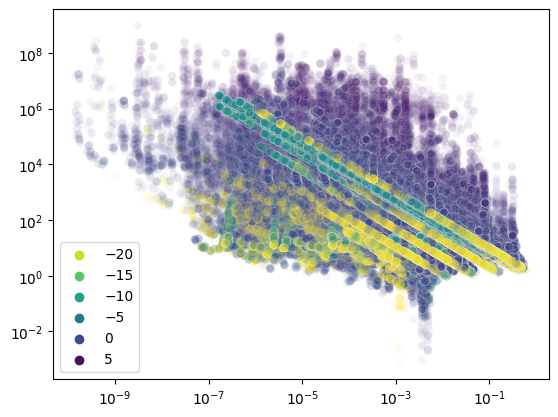

In [20]:
sns.scatterplot(x=s[1:].flatten(), y=p[1:].flatten(), hue=hue, alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')

# Find Max

In [121]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
a = {}
for f in os.listdir(sdir):
    if f.endswith('npy'):
        a[f.split('.')[0]] = np.load(os.path.join(sdir, f))

In [122]:
list(a.keys())

['fold_change',
 'response_time_wrt_species-6',
 'overshoot_asratio',
 'max_amount',
 'overshoot',
 'initial_steady_states',
 'sensitivity_wrt_species-6',
 'min_amount',
 'precision_wrt_species-6',
 'steady_states']

In [123]:
def find_top_peaks(arrs: list, n: int):
    """ Find the top n peaks across the multi-dimensional arrays in arrs """
    top_peaks = []
    if n >= 1:

        objective = arrs[0] / arrs[0].max()
        for arr in arrs[1:]:
            objective += arr / arr.max()
        top_peak = np.argmax(objective)
        top_peak_idx = np.unravel_index(top_peak, arr.shape)

        for i in range(len(arrs)):
            arrs[i][top_peak_idx] = 0

        next_top_peaks = find_top_peaks(arrs, n=n-1)
        # if (np.sum(top_peak_idx) >= np.sum(next_top_peaks[-1]) + 1) & (
        #     np.sum(top_peak_idx) <= np.sum(next_top_peaks[-1]) - 1
        # ):
        top_peaks.append(top_peak_idx)
        top_peaks = top_peaks + next_top_peaks

    return top_peaks


def filter_top_peaks(top_indices, radius: int):
    chosen = [0]
    for i, t in enumerate(top_indices[1:]):
        if (np.sum(np.abs(np.array(t) - np.array(top_indices[i]))) > radius):
            chosen.append(i+1)
    top_indices = sorted([top_indices[i] for i in chosen])
    return top_indices

### Get top peaks

In [124]:
n_top = 1000
i_spec = 1
radius = 5

pp = np.where(a['precision_wrt_species-6'] > 1e1,
              1e1, a['precision_wrt_species-6'])
# Overshoot / signal diff
oo = np.where((a['max_amount'][0] - a['initial_steady_states'][0]) == 0,
              0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))
oo = np.where(oo < 1e-4, 0, oo)
# oo = np.where(a['overshoot'] < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
# oo = np.where(oo < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
arrs = [a['sensitivity_wrt_species-6'][i_spec], pp[i_spec], oo[i_spec]]
top_indices = find_top_peaks(deepcopy(arrs), n=n_top)
n_ind = len(top_indices)
n_prev = 0
while n_ind != n_prev:
    n_prev = len(top_indices)
    top_indices = filter_top_peaks(top_indices, radius=radius)
    n_ind = len(top_indices)

print(len(top_indices))
top_indices

/tmp/ipykernel_405886/960350546.py:9: RuntimeWarning: invalid value encountered in divide
  0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))


24


[(0, 5, 0, 7, 5, 0),
 (0, 5, 2, 7, 7, 7),
 (0, 5, 2, 8, 8, 0),
 (0, 5, 2, 8, 8, 6),
 (0, 5, 3, 7, 5, 0),
 (0, 5, 8, 7, 7, 5),
 (0, 5, 8, 8, 5, 0),
 (1, 5, 0, 7, 5, 1),
 (1, 5, 1, 8, 8, 6),
 (1, 5, 2, 7, 5, 0),
 (1, 5, 2, 7, 7, 6),
 (1, 5, 3, 7, 5, 3),
 (1, 5, 6, 7, 7, 7),
 (1, 5, 6, 8, 8, 0),
 (1, 5, 8, 7, 7, 5),
 (1, 5, 8, 8, 6, 0),
 (2, 5, 0, 7, 6, 4),
 (2, 5, 1, 8, 7, 8),
 (2, 5, 1, 8, 8, 0),
 (2, 5, 1, 8, 8, 6),
 (2, 5, 2, 7, 5, 3),
 (2, 5, 6, 7, 8, 6),
 (2, 5, 6, 8, 5, 1),
 (3, 5, 0, 8, 7, 4)]

In [125]:
# param_range[top_indices]

In [126]:
print('senstivity \t overshoot \t precision')
for t in top_indices:
    print(a['sensitivity_wrt_species-6'][1][tuple(t)], '\t', a['overshoot'][1][tuple(t)], '\t', a['precision_wrt_species-6'][1][t])

senstivity 	 overshoot 	 precision
0.0006731901 	 64.93421 	 171.95262
2.6335756e-05 	 63.981613 	 3781.7456
0.0010751475 	 66.1274 	 90.01608
2.6877771e-05 	 64.3687 	 3610.5085
0.0022313015 	 64.4804 	 70.14197
0.0011566624 	 64.28614 	 82.92767
0.0010036074 	 66.018715 	 103.99409
0.00069319597 	 64.914314 	 167.24171
2.6264156e-06 	 64.42645 	 36581.82
0.0008626989 	 64.91244 	 136.26677
2.7455233e-05 	 64.31612 	 3792.3408
0.0018706791 	 63.408943 	 106.35884
0.000967163 	 64.631775 	 75.25105
0.0010670597 	 65.817696 	 90.778946
0.0011819489 	 64.26399 	 81.13783
0.0010641591 	 65.77756 	 91.1786
0.00012033151 	 67.179276 	 709.6253
1.9481195e-05 	 65.00351 	 5371.088
0.001321401 	 65.761444 	 73.42233
2.0833671e-05 	 64.00903 	 4760.6855
0.00072624383 	 63.76036 	 240.71742
0.001459302 	 63.764732 	 66.47665
0.0015013918 	 65.58143 	 68.96784
0.0015149008 	 62.40473 	 72.919334


In [127]:
config['simulation']

{'dt0': 0.01,
 't0': 0,
 't1': 100,
 'tmax': 120000,
 'solver': 'diffrax',
 'use_batch_mutations': True,
 'batch_size': 10000,
 'max_circuits': 20000,
 'device': 'gpu',
 'threshold_steady_states': 0.05,
 'use_rate_scaling': True}

### Run mini sim

In [128]:
saves = {}
for i, ti in enumerate(top_indices):
    r, analytics, y, t = mini_sim(*param_range[np.array(ti)])
    saves[i] = {
        'analytics': analytics,
        'y': y,
        't': t
    }

0 	 0.0042829374 	 62.570587 	 8122.9263
1 	 0.00026333667 	 58.205475 	 28630.807
2 	 0.0055255797 	 63.764748 	 4063.5579
3 	 0.00030694055 	 59.8797 	 24559.275
4 	 0.00467361 	 61.865067 	 10174.484
5 	 0.0064817406 	 62.931343 	 10379.587
6 	 0.006000188 	 61.682205 	 3080.577
7 	 0.0042854985 	 62.566315 	 8184.6655
8 	 0.00028622276 	 59.919586 	 26376.268
9 	 0.004309092 	 62.525955 	 8282.826
10 	 0.0002983987 	 58.609467 	 26517.594
11 	 0.0045645265 	 61.2657 	 19048.75
12 	 0.006640051 	 62.201073 	 9498.335
13 	 0.0066385297 	 64.54302 	 11506.62
14 	 0.006485428 	 62.9144 	 10227.189
15 	 0.0065398193 	 64.47145 	 11561.983
16 	 0.0033504623 	 63.132027 	 8290.651
17 	 0.00026537626 	 59.29663 	 27434.086
18 	 0.005559407 	 63.48555 	 3724.3652
19 	 0.00030318956 	 59.663864 	 24247.625
20 	 0.0042458614 	 61.87593 	 15883.705
21 	 0.006713243 	 62.51809 	 7904.1963
22 	 0.0061020865 	 61.41205 	 3146.0562
23 	 0.00417443 	 61.49781 	 2735.148


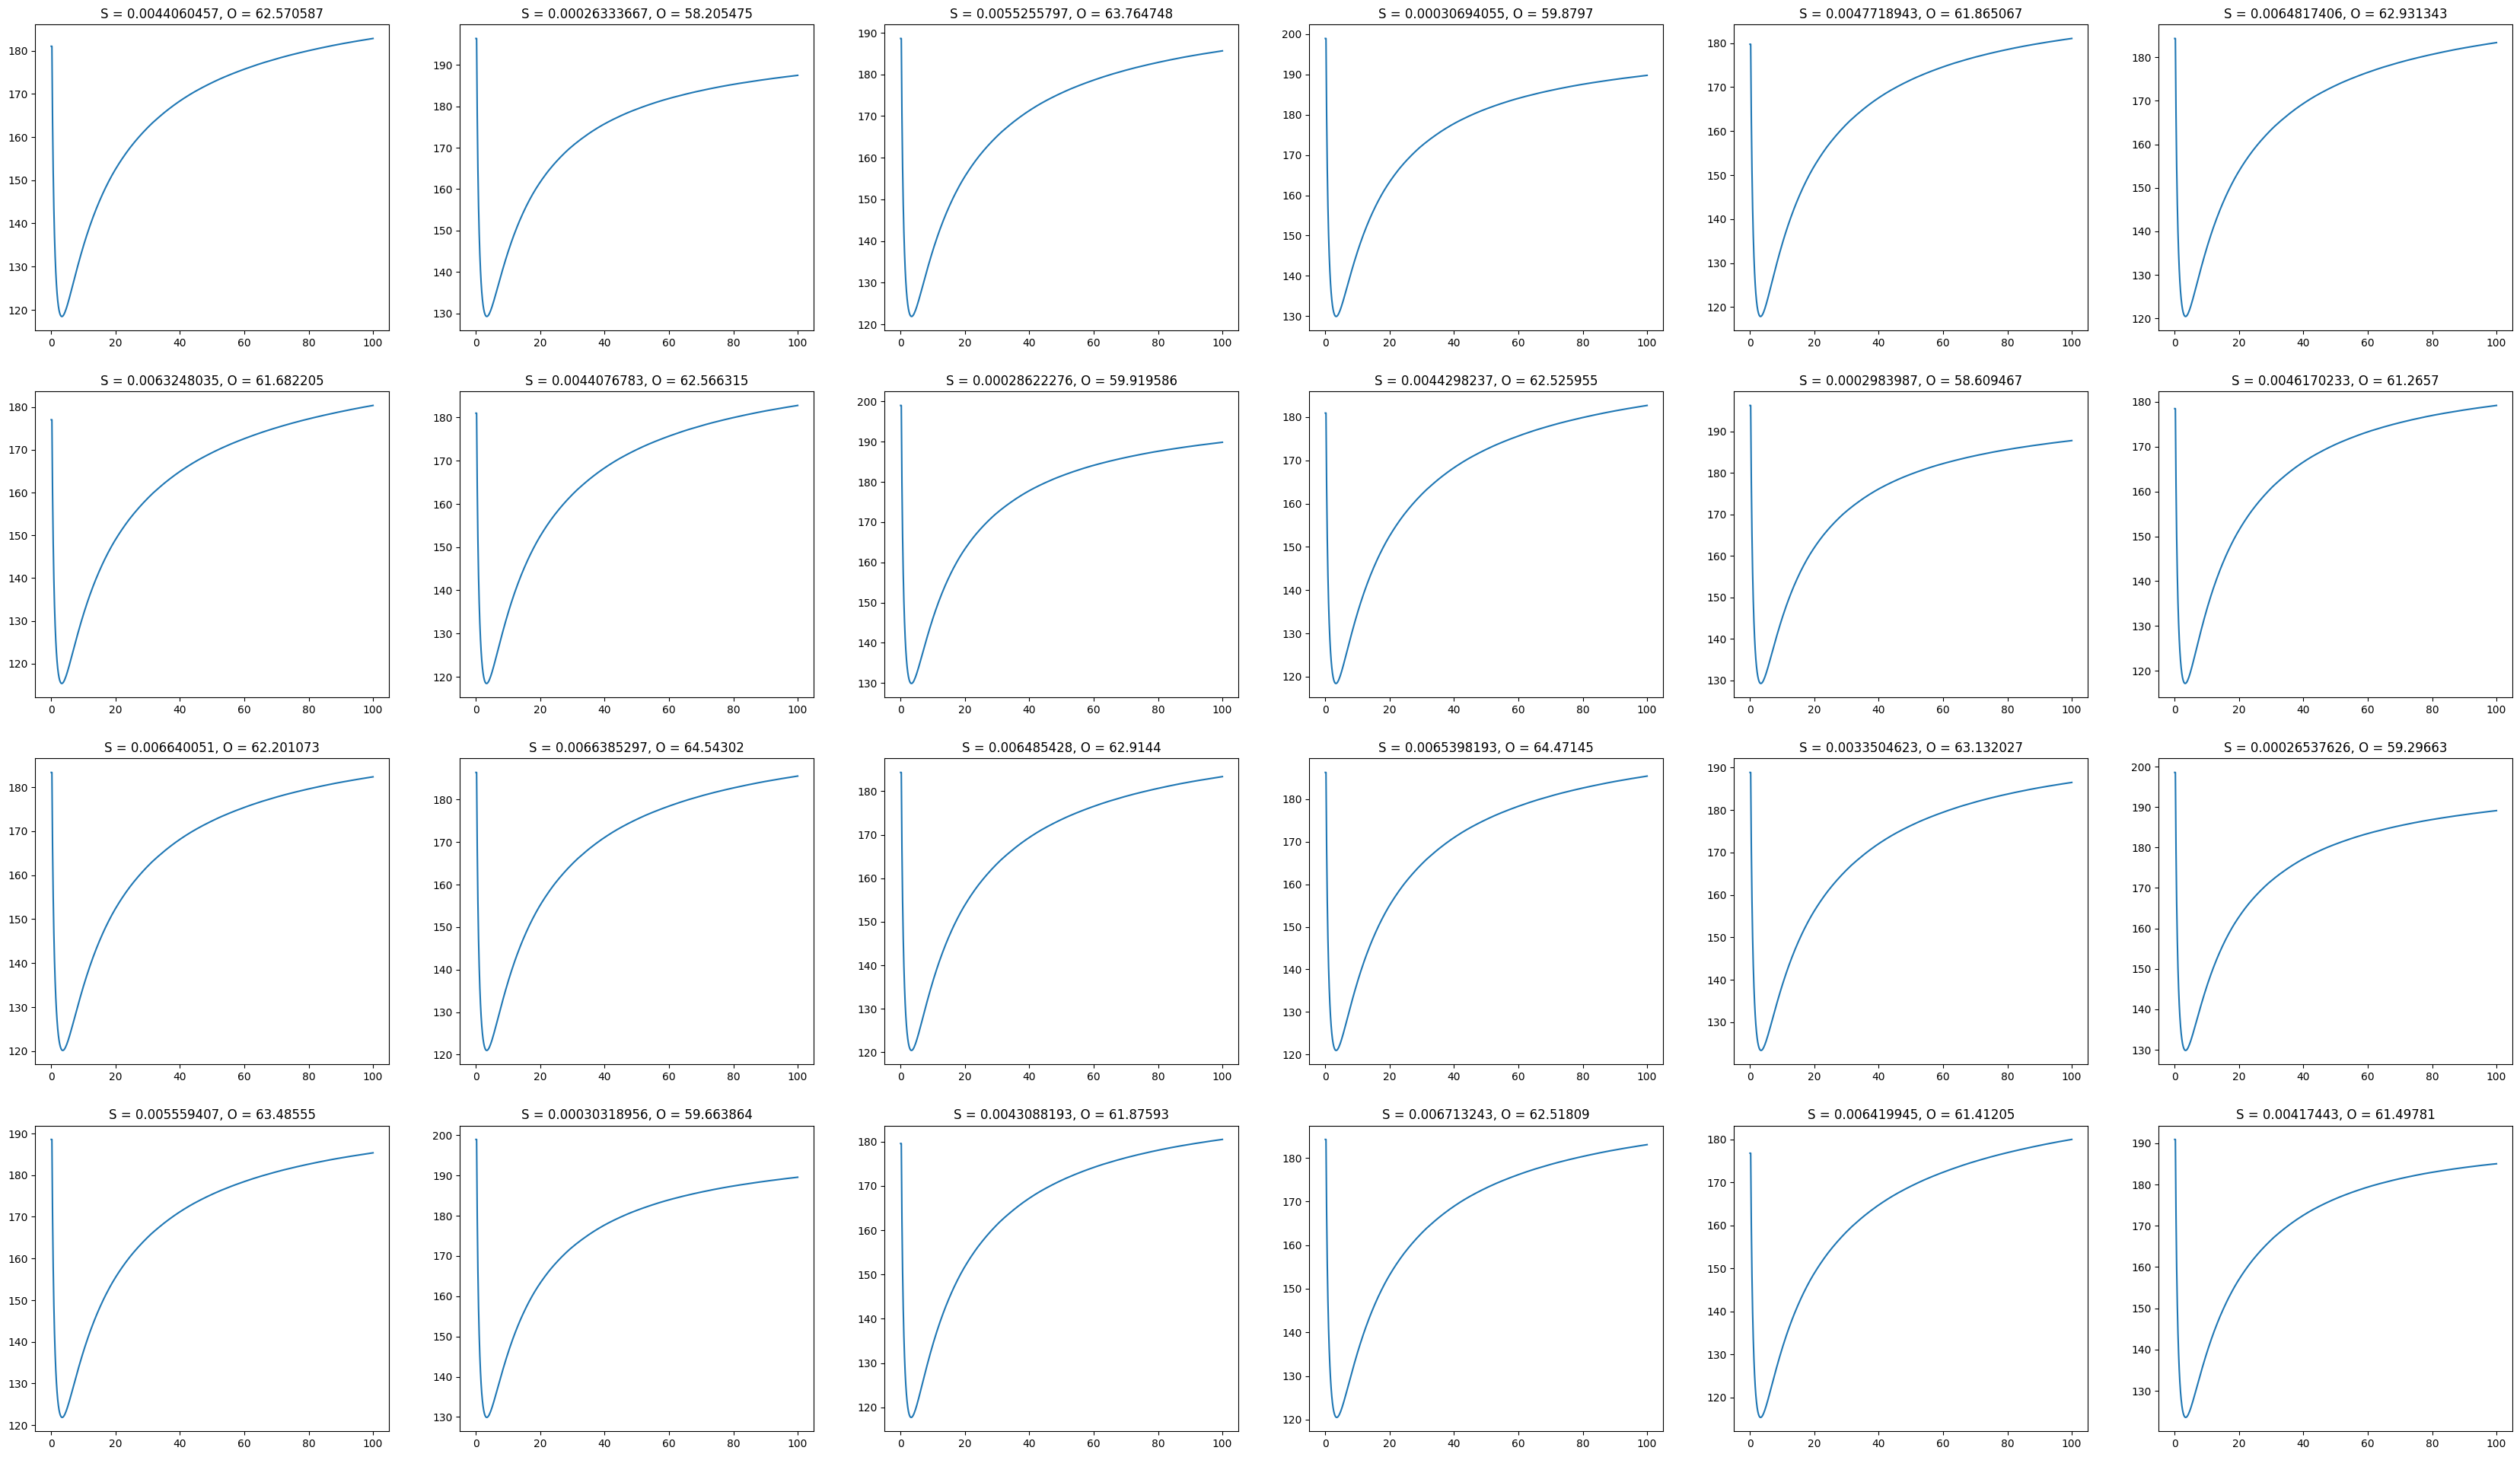

In [129]:
n_rows = np.ceil(len(saves) / 6).astype(int)
n_cols = np.ceil(len(saves) / n_rows).astype(int)
plt.figure(figsize=(7*n_cols, 6*n_rows))
for i, run in saves.items():
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.plot(run['t'], run['y'][:, 7])
    plt.title('S = ' + str(run['analytics']['sensitivity_wrt_species-6'][7]) +
              ', O = ' + str(run['analytics']['overshoot'][7]))

    sensitivity = np.absolute(np.divide(
        np.divide(
            run['analytics']['min_amount'][7] -
            run['analytics']['initial_steady_states'][7],
            run['analytics']['initial_steady_states'][7]),
        np.divide(
            run['analytics']['max_amount'][6] -
            run['analytics']['initial_steady_states'][6],
            run['analytics']['initial_steady_states'][6])
    ))
    print(i, '\t', sensitivity, '\t', run['analytics']['overshoot'][7], '\t', run['analytics']['precision_wrt_species-6'][7])

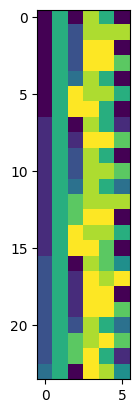

In [130]:
plt.imshow(np.log10(param_range[top_indices]))

In [166]:

unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
species = ['RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2', 'RNA_0', 'RNA_1', 'RNA_2']
inds = [i for i, s in enumerate(species) if s in unbound_species]

In [168]:
analytics['sensitivity_wrt_species-6'][:]

Array([3.0880556 , 0.17996687, 1.0277492 , 0.02246778, 0.04672105,
       0.03539252, 1.        , 0.38737464, 0.02014509], dtype=float32)

: 

In [91]:
analytics['precision_wrt_species-6']
# Array([2.0208731e+00, 7.0501550e+02, 7.0507782e+02, 5.7925303e-03,
#        6.6594379e+02, 7.3779352e+02, 7.0101660e+02, 7.0101703e+02,
#        7.0101733e+02], dtype=float32)

Array([ 0.33718005,  1.6675429 ,  1.3405542 , 25.240751  , 45.556717  ,
        4.9638042 ,  1.0338407 ,  7.673475  ,  9.342553  ], dtype=float32)

In [93]:
num_species = 3
interaction_matrices, all_interaction_strength_choices = make_interaction_matrices(
    num_species=num_species, interaction_strengths=param_range,
    num_unique_interactions=6, starting_iteration=0, end_iteration=10)

for i, interaction_strength_choices in enumerate(all_interaction_strength_choices):
    idxs = [slice(0, num_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]
    r, analytics = mini_sim(*interaction_matrices[i][np.triu_indices(num_species)])

    print(f'\nInteraction {i}:')
    print('prev', a['sensitivity_wrt_species-6'][tuple(idxs)])
    print('now', analytics['sensitivity_wrt_species-6'])
    


Interaction 0:
prev [[1.0000000e+00]
 [5.4674345e-04]
 [5.4674339e-04]]
now [1.6378406e-02 1.1446339e-04 1.1446339e-04 5.1957983e-07 5.1957983e-07
 5.1957983e-07 1.0000000e+00 3.7805100e-03 3.7805100e-03]

Interaction 1:
prev [[1.000000e+00]
 [6.481721e-04]
 [6.481721e-04]]
now [1.64462402e-02 1.14906994e-04 1.14906987e-04 5.21071684e-07
 5.21071854e-07 5.21072025e-07 1.00000000e+00 3.79665568e-03
 3.79665568e-03]

Interaction 2:
prev [[1.        ]
 [0.00202797]
 [0.00202797]]
now [1.7623227e-02 1.2270245e-04 1.2270245e-04 5.5091891e-07 5.5091897e-07
 5.5091891e-07 1.0000000e+00 4.0782723e-03 4.0782723e-03]

Interaction 3:
prev [[0.99999994]
 [0.00935953]
 [0.00935953]]
now [3.5959370e-02 2.2936380e-04 2.2936385e-04 9.0953574e-07 9.0953574e-07
 9.0953586e-07 1.0000000e+00 8.5002212e-03 8.5002203e-03]

Interaction 4:
prev [[1.        ]
 [0.02432723]
 [0.02432723]]
now [1.8440747e-01 3.6677180e-04 3.6677191e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 3.9826013e-02 3.982

In [158]:

r, analytics = mini_sim(*interaction_matrices[0][np.triu_indices(n_species)])


In [159]:
n_species = 3
for interaction_strength_choices in all_interaction_strength_choices[:1]:
    idxs = [slice(0, n_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]